<a href="https://colab.research.google.com/github/ITZ-NANO21-MC/ML-ITZ-NANO-ITZ/blob/Version-2/fcc_cat_dog_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
Batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-06-16 16:10:05--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.7’

cats_and_dogs.zip.7 100%[===================>]  67.43M   174MB/s    in 0.4s    

2025-06-16 16:10:06 (174 MB/s) - ‘cats_and_dogs.zip.7’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# 3
# Generadores
train_image_generator = train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_image_generator = train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_image_generator = train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Configuración de flujos
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=Batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=Batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,  # Directorio padre
    classes=['test'],  # Subdirectorio con imágenes
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=Batch_size,
    class_mode=None,  # Para predicción
    shuffle=False
)

# Verificación
print(f"Imágenes de entrenamiento: {train_data_gen.samples}")
print(f"Imágenes de validación: {val_data_gen.samples}")
print(f"Imágenes de prueba: {test_data_gen.samples}")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
Imágenes de entrenamiento: 2000
Imágenes de validación: 1000
Imágenes de prueba: 50


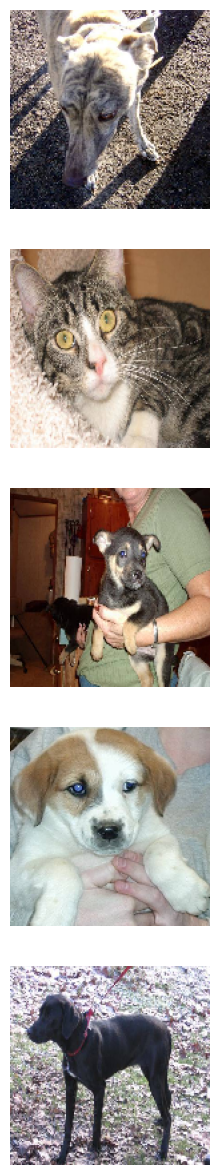

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalización de valores de píxeles (0-1)
    rotation_range=40,  # Rotación aleatoria hasta 40 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio (20% del ancho)
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio (20% del alto)
    shear_range=0.2,  # Deformación de corte aleatoria
    zoom_range=0.2,  # Zoom aleatorio hasta 20%
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Estrategia para llenar puntos creados por transformaciones
)

Found 2000 images belonging to 2 classes.


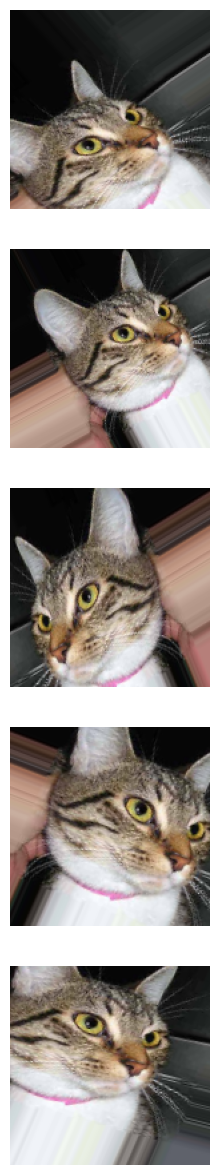

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=Batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    GlobalAveragePooling2D(),  # Reduce dimensiones manteniendo información relevante
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8

# Implementar Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Guardar los mejores pesos
)

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // Batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // Batch_size,
    callbacks=[early_stop]  # Aplicar Early Stopping
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.4860 - loss: 1.6769 - val_accuracy: 0.5089 - val_loss: 1.6153
Epoch 2/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - accuracy: 0.5312 - loss: 1.6221

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5312 - loss: 1.6221 - val_accuracy: 0.4900 - val_loss: 1.6113
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5162 - loss: 1.5976 - val_accuracy: 0.4978 - val_loss: 1.5479
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5625 - loss: 1.5479 - val_accuracy: 0.5022 - val_loss: 1.5440
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.4911 - loss: 1.5283 - val_accuracy: 0.5145 - val_loss: 1.4830
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 714ms/step - accuracy: 0.5547 - loss: 1.4850 - val_accuracy: 0.5424 - val_loss: 1.4787
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.5198 - loss: 1.4673 - val_accuracy: 0.5502 - val_loss: 1.4230
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - accuracy: 0.4141 - loss: 1.4341 - val_accuracy: 0.5580 - val_loss: 1.4193
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.5251 - loss: 1.4065 - val_accuracy: 0.5134 - val_loss: 

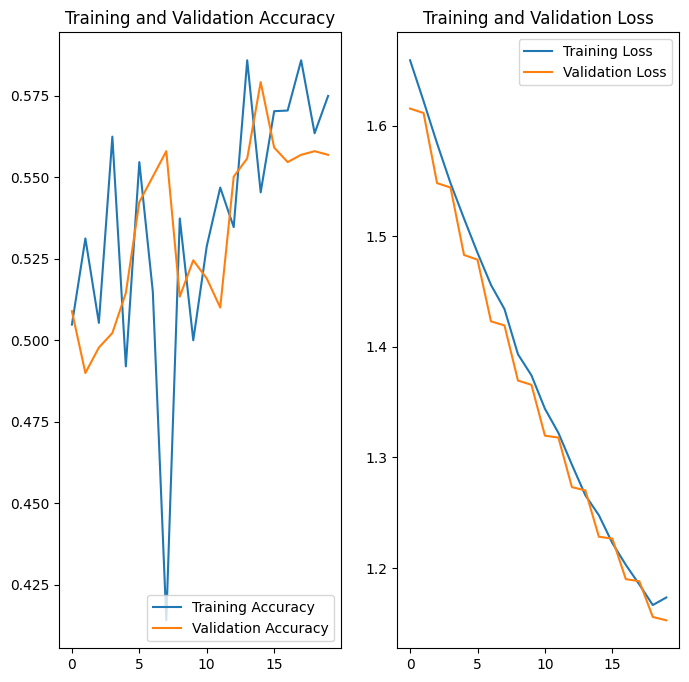

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 11

# Primero verifica que el generador de prueba esté configurado correctamente
print(f"Número de imágenes de prueba encontradas: {test_data_gen.samples}")

if test_data_gen.samples > 0:
    # Reiniciar el generador para empezar desde el principio
    test_data_gen.reset()

    # Obtener predicciones para todas las imágenes de prueba
    probabilities = model.predict(
        test_data_gen,  # Pasar el generador, no .samples
        steps=(test_data_gen.samples // Batch_size) + 1
    ).flatten()

    # Asegurarse de tomar solo las primeras 50 predicciones
    probabilities = probabilities[:50]

    # Respuestas correctas
    answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
              1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
              1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
              1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
              0, 0, 0, 0, 0, 0]

    # Calcular precisión
    correct = 0
    for probability, answer in zip(probabilities, answers):
        if round(probability) == answer:
            correct += 1

    percentage_identified = (correct / len(answers)) * 100
    passed_challenge = percentage_identified >= 63

    print(f"Tu modelo identificó correctamente el {round(percentage_identified, 2)}% de las imágenes.")

    if passed_challenge:
        print("¡Pasaste el desafío!")
    else:
        print("Aún no pasaste. Tu modelo debe identificar al menos el 63% de las imágenes.")
else:
    print("Error: No se encontraron imágenes de prueba. Verifica la configuración del directorio.")

Número de imágenes de prueba encontradas: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Tu modelo identificó correctamente el 58.0% de las imágenes.
Aún no pasaste. Tu modelo debe identificar al menos el 63% de las imágenes.
